In [4]:
import os
os.environ['PYARROW_IGNORE_TIMEZONE'] = '1'
import sys

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,roc_curve, auc
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')
RANDOM_STATE = 1234

In [5]:

# Must be included at the beginning of each new notebook. Remember to change the app name.
from pyspark.sql import SparkSession
import pyspark
import findspark
import pyspark.pandas as ps
import pyspark.sql.functions as f
from pyspark.sql.window import Window
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
spark = SparkSession.builder.appName('basics').getOrCreate()
ps.set_option('compute.ops_on_diff_frames', True)

# #Data Understanding


In [6]:
df = spark.read.csv('Europe Hotel Booking Satisfaction Score train.csv',header=True, inferSchema=True)
print("The shape of data is: ({0},{1})".format(df.count(),len(df.columns)))
df.limit(5).toPandas()

The shape of data is: (103904,17)


,id,Gender,Age,purpose_of_travel,Type of Travel,Type Of Booking,Hotel wifi service,Departure/Arrival convenience,Ease of Online booking,Hotel location,Food and drink,Stay comfort,Common Room entertainment,Checkin/Checkout service,Other service,Cleanliness,satisfaction
0,70172,Male,13,aviation,Personal Travel,Not defined,3,4,3,1,5,5,5,4,5,5,neutral or dissatisfied
1,5047,Male,25,tourism,Group Travel,Group bookings,3,2,3,3,1,1,1,1,4,1,neutral or dissatisfied
2,110028,Female,26,tourism,Group Travel,Group bookings,2,2,2,2,5,5,5,4,4,5,satisfied
3,24026,Female,25,tourism,Group Travel,Group bookings,2,5,5,5,2,2,2,1,4,2,neutral or dissatisfied
4,119299,Male,61,aviation,Group Travel,Group bookings,3,3,3,3,4,5,3,3,3,3,satisfied


In [7]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- purpose_of_travel: string (nullable = true)
 |-- Type of Travel: string (nullable = true)
 |-- Type Of Booking: string (nullable = true)
 |-- Hotel wifi service: integer (nullable = true)
 |-- Departure/Arrival  convenience: integer (nullable = true)
 |-- Ease of Online booking: integer (nullable = true)
 |-- Hotel location: integer (nullable = true)
 |-- Food and drink: integer (nullable = true)
 |-- Stay comfort: integer (nullable = true)
 |-- Common Room entertainment: integer (nullable = true)
 |-- Checkin/Checkout service: integer (nullable = true)
 |-- Other service: integer (nullable = true)
 |-- Cleanliness: integer (nullable = true)
 |-- satisfaction: string (nullable = true)



In [6]:
s = df.groupBy('satisfaction').count().orderBy('satisfaction')
df_satisfaction = s.withColumn("Percentage(%)",f.round(f.col('count')/f.sum('count').over(Window.partitionBy())*100,2))
y, x= df_satisfaction.select('satisfaction').collect(), df_satisfaction.select('count').collect()
df_satisfaction.show()

23/09/29 02:19:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/09/29 02:19:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/09/29 02:19:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/09/29 02:19:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/09/29 02:19:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+--------------------+-----+-------------+
|        satisfaction|count|Percentage(%)|
+--------------------+-----+-------------+
|neutral or dissat...|58879|        56.67|
|           satisfied|45025|        43.33|
+--------------------+-----+-------------+



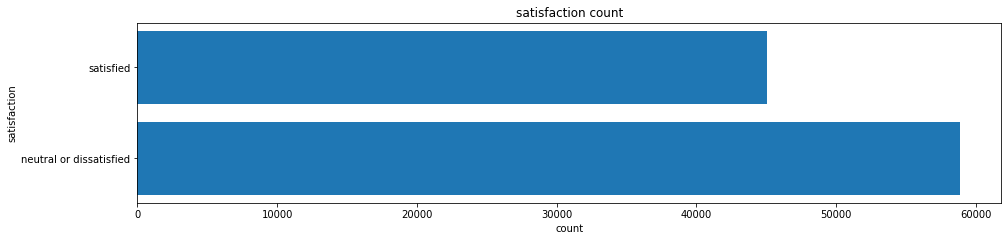

In [7]:
fig = plt.figure(figsize = (12,2.5))
ax = fig.add_axes([0,0,1,1])
ax.barh(np.array(y).flatten(),np.array(x).flatten())
ax.set_yticks(np.array(y).flatten())
ax.set_ylabel('satisfaction')
ax.set_xlabel('count')
ax.set_title('satisfaction count')
plt.show()

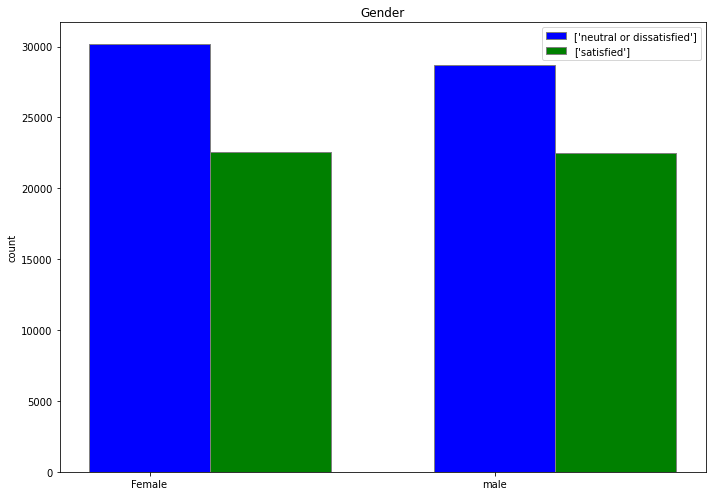

In [8]:
gender = np.array(df.groupBy('Gender','satisfaction').count().
                groupBy('satisfaction').pivot('Gender').sum("count").
                orderBy('satisfaction').collect())
gender
labels = ['Female','male']
neutral_dis = gender[0,1:].astype('int')
satis = gender[1,1:].astype('int')
width = 0.35  

x = np.arange(len(labels)) 

br1 = np.arange(len(neutral_dis))
br2 = [x + width for x in br1]

fig, ax = plt.subplots(figsize=(10, 7))
plt.bar(br1, neutral_dis, color ='b', width = width,
        edgecolor ='grey', label =gender[0,:1])
plt.bar(br2, satis, color ='g', width = width,
        edgecolor ='grey', label =gender[1,:1])

ax.set_ylabel('count')
ax.set_title('Gender')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()

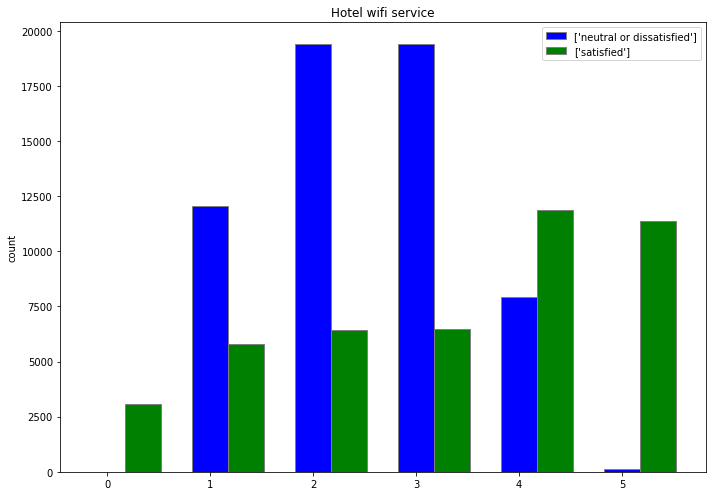

In [9]:
wifi = np.array(df.groupBy('Hotel wifi service','satisfaction').
                count().groupBy('satisfaction').pivot('Hotel wifi service').
                sum("count").orderBy('satisfaction').collect())
wifi
labels = ['0','1','2','3','4','5']
neutral_dis = wifi[0,1:].astype('int')
satis = wifi[1,1:].astype('int')
width = 0.35  

x = np.arange(len(labels)) 
br1 = np.arange(len(neutral_dis))
br2 = [x + width for x in br1]

fig, ax = plt.subplots(figsize=(10, 7))
plt.bar(br1, neutral_dis, color ='b', width = width,
        edgecolor ='grey', label =wifi[0,:1])
plt.bar(br2, satis, color ='g', width = width,
        edgecolor ='grey', label =wifi[1,:1])

ax.set_ylabel('count')
ax.set_title('Hotel wifi service')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()

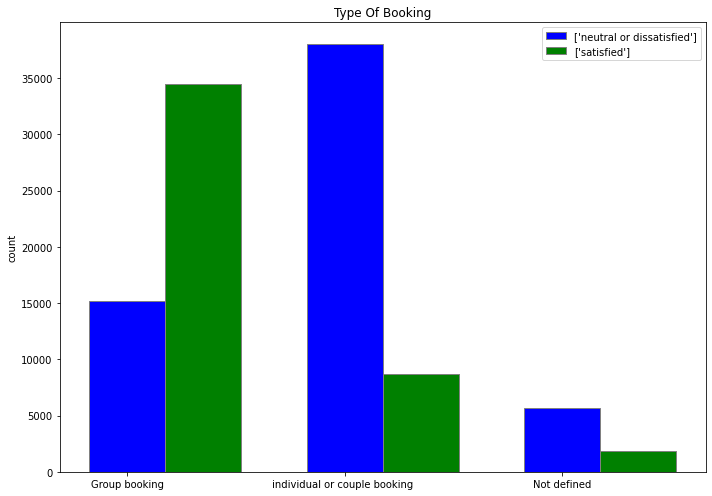

In [10]:
booking = np.array(df.groupBy('Type Of Booking','satisfaction').count().
                groupBy('satisfaction').pivot('Type Of Booking').sum("count").
                orderBy('satisfaction').collect())
booking
labels = ['Group booking','individual or couple booking ','Not defined']
neutral_dis = booking[0,1:].astype('int')
satis = booking[1,1:].astype('int')
width = 0.35  

x = np.arange(len(labels)) 

br1 = np.arange(len(neutral_dis))
br2 = [x + width for x in br1]

fig, ax = plt.subplots(figsize=(10, 7))
plt.bar(br1, neutral_dis, color ='b', width = width,
        edgecolor ='grey', label =booking[0,:1])
plt.bar(br2, satis, color ='g', width = width,
        edgecolor ='grey', label =booking[1,:1])

ax.set_ylabel('count')
ax.set_title('Type Of Booking')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()

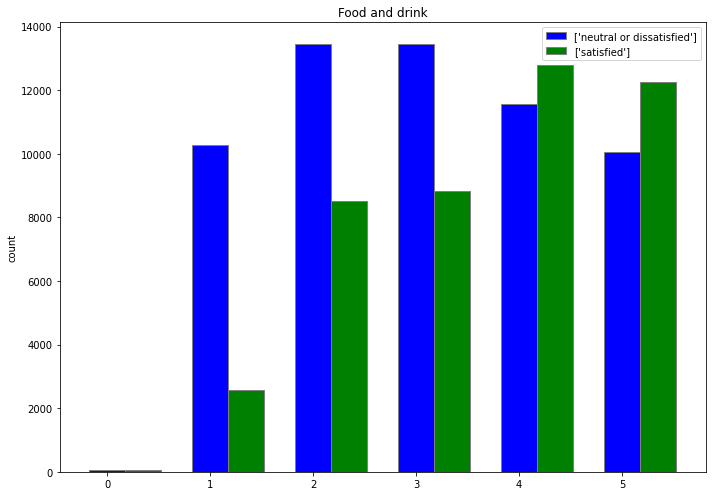

In [11]:
foodanddrink = np.array(df.groupBy('Food and drink','satisfaction').count().
                groupBy('satisfaction').pivot('Food and drink').sum("count").
                orderBy('satisfaction').collect())
foodanddrink
labels = ['0','1','2','3','4','5']
neutral_dis = foodanddrink[0,1:].astype('int')
satis = foodanddrink[1,1:].astype('int')
width = 0.35  

x = np.arange(len(labels)) 
br1 = np.arange(len(neutral_dis))
br2 = [x + width for x in br1]

fig, ax = plt.subplots(figsize=(10, 7))
plt.bar(br1, neutral_dis, color ='b', width = width,
        edgecolor ='grey', label =foodanddrink[0,:1])
plt.bar(br2, satis, color ='g', width = width,
        edgecolor ='grey', label =foodanddrink[1,:1])

ax.set_ylabel('count')
ax.set_title('Food and drink')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()

In [12]:
stay_comfort = np.array(df.groupBy('Stay comfort','satisfaction').count().
                groupBy('satisfaction').pivot('Stay comfort').sum("count").
                orderBy('satisfaction').collect())
stay_comfort

array([['neutral or dissatisfied', 1, 9380, 11558, 14741, 13940, 9259],
       ['satisfied', None, 2695, 3339, 3955, 17825, 17211]], dtype=object)

In [13]:
stay_comfort[1,1:]

array([None, 2695, 3339, 3955, 17825, 17211], dtype=object)

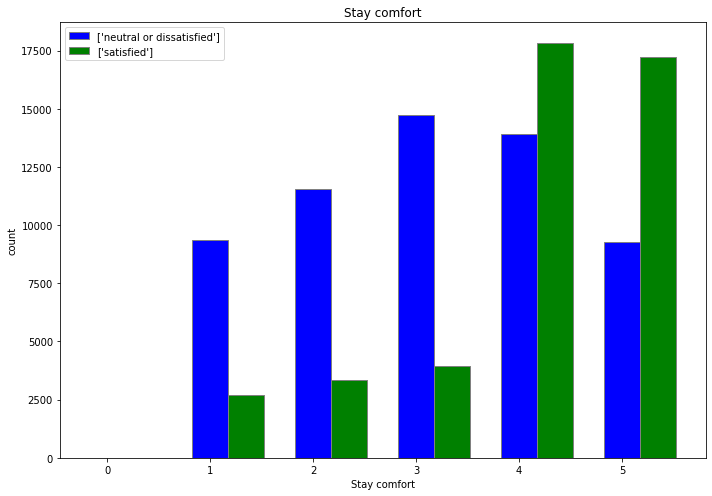

In [16]:
labels = ['0','1','2','3','4','5']
neutral_dis = stay_comfort[0,1:].astype('int')
stay_comfort[1,1]=0
satis = stay_comfort[1,1:].astype('int')
width = 0.35  

x = np.arange(len(labels))  

br1 = np.arange(len(neutral_dis))
br2 = [x + width for x in br1]

fig, ax = plt.subplots(figsize=(10, 7))
plt.bar(br1, neutral_dis, color ='b', width = width,
        edgecolor ='grey', label =stay_comfort[0,:1])
plt.bar(br2, satis, color ='g', width = width,
        edgecolor ='grey', label =stay_comfort[1,:1])

ax.set_ylabel('count')
ax.set_xlabel('Stay comfort')
ax.set_title('Stay comfort')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

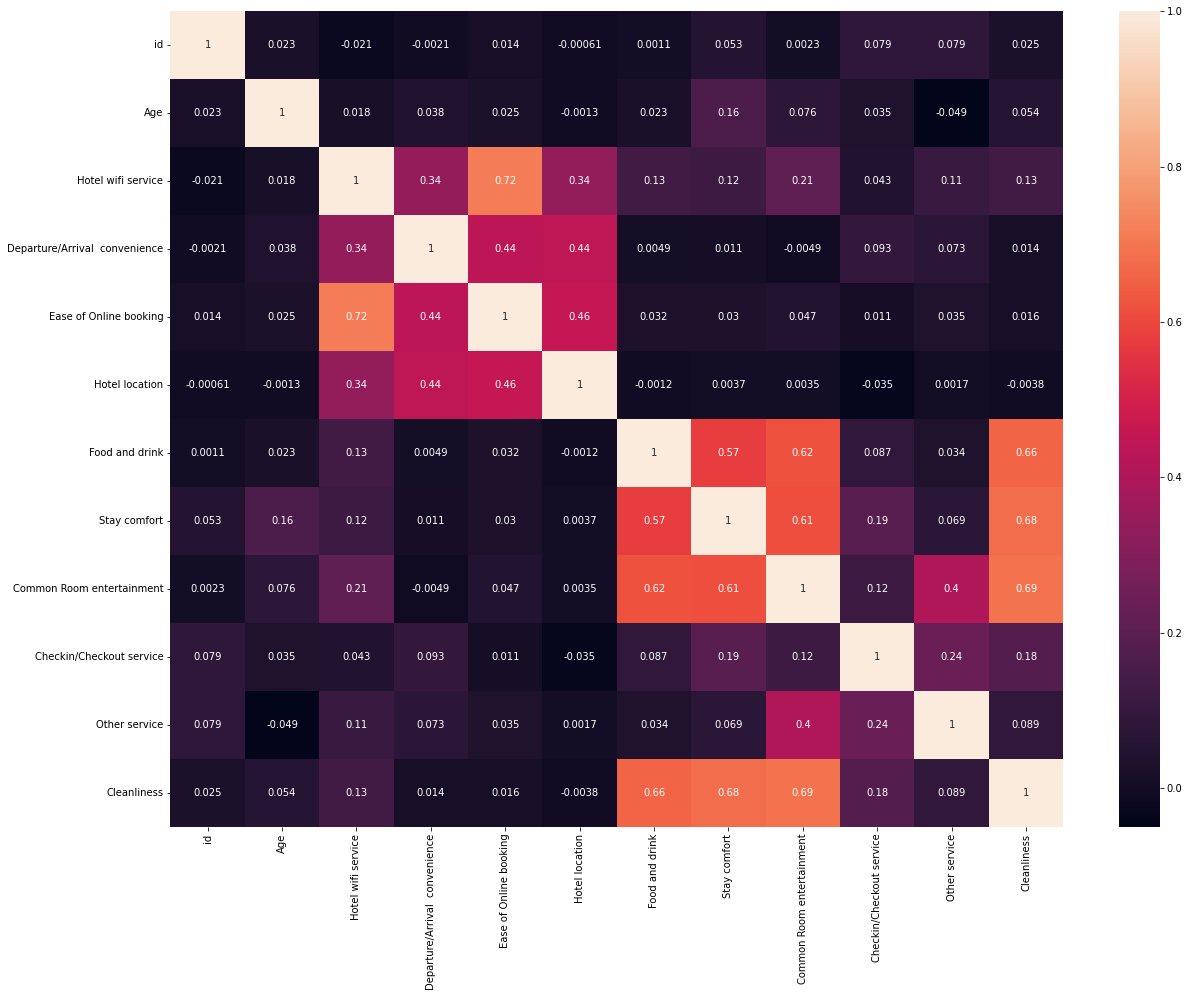

In [17]:
correlation_map = df.toPandas().corr()
top_feature = correlation_map.index
plt.figure(figsize=(20,15))
sns.heatmap(df.toPandas()[top_feature].corr(),annot=True)
plt.show

In [8]:
from pyspark.sql.functions import isnan,when,count,col
df_count = df.count()
df.select([count(when(isnan(c)| col(c).isNull(),c)).alias(c) for c in df.columns]).show()

+---+------+---+-----------------+--------------+---------------+------------------+------------------------------+----------------------+--------------+--------------+------------+-------------------------+------------------------+-------------+-----------+------------+
| id|Gender|Age|purpose_of_travel|Type of Travel|Type Of Booking|Hotel wifi service|Departure/Arrival  convenience|Ease of Online booking|Hotel location|Food and drink|Stay comfort|Common Room entertainment|Checkin/Checkout service|Other service|Cleanliness|satisfaction|
+---+------+---+-----------------+--------------+---------------+------------------+------------------------------+----------------------+--------------+--------------+------------+-------------------------+------------------------+-------------+-----------+------------+
|  0|     0|  0|                0|             0|              0|                 0|                             0|                     0|             0|             0|           0|   

In [9]:
print("The shape of data is: ({0},{1})".format(df.count(),len(df.columns)))

The shape of data is: (103904,17)


In [10]:
completeness = (103904-25)/103904
print(completeness)

0.9997593932861103


In [11]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- purpose_of_travel: string (nullable = true)
 |-- Type of Travel: string (nullable = true)
 |-- Type Of Booking: string (nullable = true)
 |-- Hotel wifi service: integer (nullable = true)
 |-- Departure/Arrival  convenience: integer (nullable = true)
 |-- Ease of Online booking: integer (nullable = true)
 |-- Hotel location: integer (nullable = true)
 |-- Food and drink: integer (nullable = true)
 |-- Stay comfort: integer (nullable = true)
 |-- Common Room entertainment: integer (nullable = true)
 |-- Checkin/Checkout service: integer (nullable = true)
 |-- Other service: integer (nullable = true)
 |-- Cleanliness: integer (nullable = true)
 |-- satisfaction: string (nullable = true)



# #Data Preparation

In [12]:
df.describe().show()

+-------+-----------------+------+------------------+-----------------+---------------+---------------+------------------+------------------------------+----------------------+------------------+------------------+------------------+-------------------------+------------------------+------------------+------------------+--------------------+
|summary|               id|Gender|               Age|purpose_of_travel| Type of Travel|Type Of Booking|Hotel wifi service|Departure/Arrival  convenience|Ease of Online booking|    Hotel location|    Food and drink|      Stay comfort|Common Room entertainment|Checkin/Checkout service|     Other service|       Cleanliness|        satisfaction|
+-------+-----------------+------+------------------+-----------------+---------------+---------------+------------------+------------------------------+----------------------+------------------+------------------+------------------+-------------------------+------------------------+------------------+---------

In [13]:
df_clean = df.drop('id')

In [14]:
for col in df_clean.dtypes:
    print(col[0])

Gender
Age
purpose_of_travel
Type of Travel
Type Of Booking
Hotel wifi service
Departure/Arrival  convenience
Ease of Online booking
Hotel location
Food and drink
Stay comfort
Common Room entertainment
Checkin/Checkout service
Other service
Cleanliness
satisfaction


In [15]:
from pyspark.sql.functions import isnan,when,count,col
df_clean_count = df_clean.count()
df_clean.select([count(when(isnan(c)| col(c).isNull(),c)).alias(c) for c in df_clean.columns]).show()

+------+---+-----------------+--------------+---------------+------------------+------------------------------+----------------------+--------------+--------------+------------+-------------------------+------------------------+-------------+-----------+------------+
|Gender|Age|purpose_of_travel|Type of Travel|Type Of Booking|Hotel wifi service|Departure/Arrival  convenience|Ease of Online booking|Hotel location|Food and drink|Stay comfort|Common Room entertainment|Checkin/Checkout service|Other service|Cleanliness|satisfaction|
+------+---+-----------------+--------------+---------------+------------------+------------------------------+----------------------+--------------+--------------+------------+-------------------------+------------------------+-------------+-----------+------------+
|     0|  0|                0|             0|              0|                 0|                             0|                     0|             0|             0|           0|                   

In [16]:
print("The shape of data is: ({0},{1})".format(df_clean.count(),len(df_clean.columns)))

The shape of data is: (103904,16)


In [17]:
#df_clean.show()

In [18]:
from pyspark.sql.functions import isnan, when, count, col, mean
# Calculate the mean value of the "Cleanliness" column
mean_cleanliness = df_clean.select(mean("Cleanliness")).collect()[0][0]
# Fill missing values in the "Cleanliness" column with the mean value
df_clean2 = df_clean.withColumn("Cleanliness", when(isnan(col("Cleanliness"))
                                                   | col("Cleanliness").isNull(), 
                                                    mean_cleanliness).otherwise(col("Cleanliness")))

df_clean2_count = df_clean2.count()
df_clean2.select([count(when(isnan(c)| col(c).isNull(),c)).alias(c) for c in df_clean2.columns]).show()

+------+---+-----------------+--------------+---------------+------------------+------------------------------+----------------------+--------------+--------------+------------+-------------------------+------------------------+-------------+-----------+------------+
|Gender|Age|purpose_of_travel|Type of Travel|Type Of Booking|Hotel wifi service|Departure/Arrival  convenience|Ease of Online booking|Hotel location|Food and drink|Stay comfort|Common Room entertainment|Checkin/Checkout service|Other service|Cleanliness|satisfaction|
+------+---+-----------------+--------------+---------------+------------------+------------------------------+----------------------+--------------+--------------+------------+-------------------------+------------------------+-------------+-----------+------------+
|     0|  0|                0|             0|              0|                 0|                             0|                     0|             0|             0|           0|                   

In [19]:
df_clean2.printSchema()
df_clean2.select("Cleanliness").show()

root
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- purpose_of_travel: string (nullable = true)
 |-- Type of Travel: string (nullable = true)
 |-- Type Of Booking: string (nullable = true)
 |-- Hotel wifi service: integer (nullable = true)
 |-- Departure/Arrival  convenience: integer (nullable = true)
 |-- Ease of Online booking: integer (nullable = true)
 |-- Hotel location: integer (nullable = true)
 |-- Food and drink: integer (nullable = true)
 |-- Stay comfort: integer (nullable = true)
 |-- Common Room entertainment: integer (nullable = true)
 |-- Checkin/Checkout service: integer (nullable = true)
 |-- Other service: integer (nullable = true)
 |-- Cleanliness: double (nullable = true)
 |-- satisfaction: string (nullable = true)

+------------------+
|       Cleanliness|
+------------------+
|               5.0|
|               1.0|
|               5.0|
|               2.0|
|               3.0|
|               1.0|
|               2.0|
|           

In [20]:
# Convert the "Cleanliness" column to an integer
df_clean2 = df_clean2.withColumn("Cleanliness", df_clean2["Cleanliness"].cast("int"))

In [21]:
# Show the "Cleanliness" column in the DataFrame
df_clean2.printSchema()
df_clean2.select("Cleanliness").show()

root
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- purpose_of_travel: string (nullable = true)
 |-- Type of Travel: string (nullable = true)
 |-- Type Of Booking: string (nullable = true)
 |-- Hotel wifi service: integer (nullable = true)
 |-- Departure/Arrival  convenience: integer (nullable = true)
 |-- Ease of Online booking: integer (nullable = true)
 |-- Hotel location: integer (nullable = true)
 |-- Food and drink: integer (nullable = true)
 |-- Stay comfort: integer (nullable = true)
 |-- Common Room entertainment: integer (nullable = true)
 |-- Checkin/Checkout service: integer (nullable = true)
 |-- Other service: integer (nullable = true)
 |-- Cleanliness: integer (nullable = true)
 |-- satisfaction: string (nullable = true)

+-----------+
|Cleanliness|
+-----------+
|          5|
|          1|
|          5|
|          2|
|          3|
|          1|
|          2|
|          4|
|          3|
|          2|
|          2|
|          1|
|          

In [23]:
from pyspark.sql.functions import when, col
import pyspark.pandas as ps

# Create a new column "satisfaction_encoded" based on the mapping
df_encoded = df_clean2.withColumn(
    "customer_satisfaction",
    when(col("satisfaction") == "neutral or dissatisfied", 0)
    .when(col("satisfaction") == "satisfied", 1)
    .otherwise(None)
)

# Show the updated DataFrame
df_encoded.select("satisfaction", "customer_satisfaction").show()


+--------------------+---------------------+
|        satisfaction|customer_satisfaction|
+--------------------+---------------------+
|neutral or dissat...|                    0|
|neutral or dissat...|                    0|
|           satisfied|                    1|
|neutral or dissat...|                    0|
|           satisfied|                    1|
|neutral or dissat...|                    0|
|neutral or dissat...|                    0|
|           satisfied|                    1|
|neutral or dissat...|                    0|
|neutral or dissat...|                    0|
|neutral or dissat...|                    0|
|neutral or dissat...|                    0|
|neutral or dissat...|                    0|
|           satisfied|                    1|
|neutral or dissat...|                    0|
|neutral or dissat...|                    0|
|           satisfied|                    1|
|           satisfied|                    1|
|           satisfied|                    1|
|neutral o

## 3.4 Integrate various data sources